In [1]:
#RUN ME FIRST (ONCE)
!wget http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
!tar -xzf simple-examples.tgz
 

--2019-04-23 13:26:16--  http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 147.229.9.23, 2001:67c:1220:809::93e5:917
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|147.229.9.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34869662 (33M) [application/x-gtar]
Saving to: ‘simple-examples.tgz.7’

simple-examples.tgz 100%[===================>]  33.25M  2.91MB/s    in 13s     

2019-04-23 13:26:29 (2.58 MB/s) - ‘simple-examples.tgz.7’ saved [34869662/34869662]



In [0]:

# -*- coding: utf-8 -*-
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
from tqdm import tqdm_notebook
import pandas as pd
import matplotlib 
import tensorflow as tf
import collections
import os

 
"""Utilities for parsing PTB text files."""
def _read_words(filename):
  with tf.gfile.GFile(filename, "r") as f:
    return f.read().replace("\n", "<eos>").split()
 
 
def _build_vocab(filename):
  data = _read_words(filename)
 
  counter = collections.Counter(data)
  count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))
 
  words, _ = list(zip(*count_pairs))
  word_to_id = dict(zip(words, range(len(words))))
 
  return word_to_id
 
 
def _file_to_word_ids(filename, word_to_id):
  data = _read_words(filename)
  return [word_to_id[word] for word in data]
 
 
def ptb_raw_data(data_path=None):
  """Load PTB raw data from data directory "data_path".
 
  Reads PTB text files, converts strings to integer ids,
  and performs mini-batching of the inputs.
 
  The PTB dataset comes from Tomas Mikolov's webpage:
 
  http://www.fit.vutbr.cz/~imikolov/rnnlm/simple-examples.tgz
 
  Args:
    data_path: string path to the directory where simple-examples.tgz has
      been extracted.
 
  Returns:
    tuple (train_data, valid_data, test_data, vocabulary)
    where each of the data objects can be passed to PTBIterator.
  """
 
  train_path = os.path.join(data_path, "ptb.train.txt")
  valid_path = os.path.join(data_path, "ptb.valid.txt")
  test_path = os.path.join(data_path, "ptb.test.txt")
 
  word_to_id = _build_vocab(train_path)
  train_data = _file_to_word_ids(train_path, word_to_id)
  valid_data = _file_to_word_ids(valid_path, word_to_id)
  test_data = _file_to_word_ids(test_path, word_to_id)
  vocabulary = len(word_to_id)
  return train_data, valid_data, test_data, vocabulary
 
 
def ptb_iterator(raw_data, batch_size, num_steps):
  """Iterate on the raw PTB data.
 
  This generates batch_size pointers into the raw PTB data, and allows
  minibatch iteration along these pointers.
 
  Args:
    raw_data: one of the raw data outputs from ptb_raw_data.
    batch_size: int, the batch size.
    num_steps: int, the number of unrolls.
 
  Yields:
    Pairs of the batched data, each a matrix of shape [batch_size, num_steps].
    The second element of the tuple is the same data time-shifted to the
    right by one.
 
  Raises:
    ValueError: if batch_size or num_steps are too high.
  """
  raw_data = np.array(raw_data, dtype=np.int32)
 
  data_len = len(raw_data)
  batch_len = data_len // batch_size
  data = np.zeros([batch_size, batch_len], dtype=np.int32)
  for i in range(batch_size):
    data[i] = raw_data[batch_len * i:batch_len * (i + 1)]
 
  epoch_size = (batch_len - 1) // num_steps
 
  if epoch_size == 0:
    raise ValueError("epoch_size == 0, decrease batch_size or num_steps")
 
  for i in range(epoch_size):
    x = data[:, i*num_steps:(i+1)*num_steps]
    y = data[:, i*num_steps+1:(i+1)*num_steps+1]
    yield (x, y)
    
DATA_PATH = "simple-examples/data" 
HIDDEN_SIZE = 256          
NUM_LAYERS = 1
VOCAB_SIZE = 10000         
                             

LEARNING_RATE = 1 
TRAIN_BATCH_SIZE = 100     
TRAIN_NUM_STEP = 20       


EVAL_BATCH_SIZE = 100      
EVAL_NUM_STEP = 1           
NUM_EPOCH = 20
KEEP_PROB = 0.65
MAX_GRAD_NORM = 5   


def add_placeholders(batch_size, num_steps):
    """Generates placeholder variables to represent the input tensors.

    These placeholders are used as inputs by the rest of the model and will be 
    fed data during training. 
    Hint: You might find tf.placeholder useful.

    Returns:
      input_data: Input placeholder tensor of  shape (batch_size, num_step), type tf.int32
      targets: Labels placeholder tensor of shape (batch_size, num_steps), type tf.int32

    """
    ### YOUR CODE HERE (~2-3 lines)
    input_data = tf.placeholder(tf.int32,[batch_size, num_steps])
    targets = tf.placeholder(tf.int32,[batch_size, num_steps])
    return input_data,targets
    ### END YOUR CODE


def add_rnn_cell(HIDDEN_SIZE,batch_size,KEEP_PROB,is_training,num_steps):
    """
    TODO: In the code below, 
    - define the recurrent cell using tf.nn.rnn_cell.LSTMCell
       and apply dropout using tf.nn.rnn_cell.DropoutWrapper at training time.
    - define the initial state for the cell.
    Hint: Each LSTMCell instance has a zero_state method.

    Args:
      - HIDDEN_SIZE - the size of the hidden layer.
      - batch_size - the size of the batch
      - KEEP_PROB - the probability we will not apply dropout to a neuron. 
      - VOCAB_SIZE - the size of the vocabulary.
      - is_training - boolean to indicate if we are training or evaluating.
      - num_steps - the length to unroll the RNN.
    Returns:
    - lstm_cell - a lstm cell with HIDDEN_SIZE neurons.
    - initial_state - the zero state for the cell 

    """      
    ### YOUR CODE HERE (~3-4 lines)
    print('r')
    lstm_cell = tf.nn.rnn_cell.LSTMCell(HIDDEN_SIZE)
    if is_training:
      lstm_cell = tf.nn.rnn_cell.DropoutWrapper(lstm_cell,output_keep_prob=KEEP_PROB)
    cell = tf.nn.rnn_cell.MultiRNNCell([lstm_cell]*NUM_LAYERS)
    initial_state = cell.zero_state(batch_size,tf.float32)
    return cell,initial_state
    ### END YOUR CODE




def add_embedding_op(input_data,VOCAB_SIZE, HIDDEN_SIZE,KEEP_PROB,is_training):
    """

    TODO: In the code below, 
    - Create a [VOCAB_SIZE, HIDDEN_SIZE] matrix using tf.get_variable to
      represent the embedding of our vocabulary
    - Read the embeddings of the input. 
    - Apply dropout to the inputs at training time.

    Hint: You might find the following methods helpful: tf.get_variable, 
    tf.nn.dropout and tf.nn.embedding_lookup 

    Args:
      - input_data - a tensor of size [batch_size, num_steps].
      - VOCAB_SIZE - the size of the vocabulary.
      - HIDDEN_SIZE - the size of the hidden layer.
      - KEEP_PROB - the probability we will not apply dropout to a neuron. 
      - is_training - boolean to indicate if we are training or evaluating.
    Returns:
      - inputs - a tensor of size (batch_size, num_steps, HIDDEN_SIZE) representing
        the embedding for the current inputs.

    """
    ### YOUR CODE HERE (~3-4 lines)
    with tf.variable_scope("add_embedding_op", reuse=tf.AUTO_REUSE):
      embeddings = tf.get_variable("embeddings",[VOCAB_SIZE, HIDDEN_SIZE])
    inputs = tf.nn.embedding_lookup(embeddings,input_data)
    if is_training:
      inputs = tf.nn.dropout(inputs,KEEP_PROB)
    return inputs
    ### END YOUR CODE


def add_prediction_op(cell,inputs,initial_state,VOCAB_SIZE):
    """ 
    TODO: In the code below, 
      - use tf.nn.static_rnn with the initial_state.
      - return the final state from tf.nn.static_rnn.
      - apply a dense layer with VOCAB_SIZE units on the output from 
        tf.nn.static_rnn and return the logits.
    Args:
      - cell - the rnn cell.
      - inputs - a tensor of size (batch_size, num_steps, HIDDEN_SIZE).
      - initial_state - the initial state of the rnn cell.

    Returns:
      - logits - the result of the dense layer.
      - state - the final_state of the rnn.

    """
    ### YOUR CODE HERE (~3-4 lines)
    print('shape: ',inputs.shape)
    t = tf.cast(inputs,tf.float32)
    t = tf.unstack(t,axis=1)
    #print('len: ',len(t),' shape: ',t[0].shape)
    output,final_state = tf.nn.static_rnn(cell,t,initial_state)
    output = tf.stack(output,axis=1)
    logits = tf.layers.dense(output,VOCAB_SIZE)
    return logits, final_state
    ### END YOUR CODE


def add_loss_op(logits,labels,batch_size):
    """ Defines the CE loss operation within the computation graph and return the perplexity

    TODO: In the code below, 
      - Use tf.nn.sparse_softmax_cross_entropy_with_logits to define your loss.
      - Calculate the perplexity w.r.t the batch size.

    Args:
      - logits - the result of the dense layer in the graph
      - labels - the correct labels for the next word in sentence as indices in 
        the vocabulary.
      - batch_size - the size of the batch.
    Returns:
      - loss - the perplexity for the current batch.


    """
    ### YOUR CODE HERE (~2-4 lines)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    cost = tf.reduce_sum(loss)/batch_size
    #perp = tf.exp(loss)
    print('perp: ',cost)
    return cost
    ### END YOUR CODE


class RNNModel(tf.keras.Model):
    def __init__(self, is_training, batch_size, num_steps):
        super(RNNModel, self).__init__()
        self.batch_size = batch_size 
        self.num_steps = num_steps 
        
        self.input_data,self.targets = add_placeholders(self.batch_size, self.num_steps) 
        
        self.cell,self.initial_state =  add_rnn_cell(HIDDEN_SIZE,batch_size,KEEP_PROB,is_training,self.num_steps)
        
        self.inputs = add_embedding_op(self.input_data,VOCAB_SIZE, HIDDEN_SIZE,KEEP_PROB,is_training)
        print( self.inputs)
        self.logits,self.final_state = add_prediction_op(self.cell,self.inputs,self.initial_state,VOCAB_SIZE)
        
        self.loss = add_loss_op(self.logits,self.targets,self.batch_size)

       
        if not is_training: return

        trainable_variables = tf.trainable_variables()
        
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(self.loss, trainable_variables), MAX_GRAD_NORM)

       
        optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)

     
        self.train_op = optimizer.apply_gradients(zip(grads, trainable_variables))
      


def run_epoch(session, model, data, train_op, output_log,pbar=None):
   
    total_loss = 0.0
    iters = 0
    state = session.run(model.initial_state)
    prep_list=[]
    for step, (x, y) in (enumerate(
        ptb_iterator(data, model.batch_size, model.num_steps))):
        
        loss,state,_ = session.run(
            [model.loss,model.final_state, train_op],
            {model.input_data: x, model.targets: y,model.initial_state:state})
       
        total_loss += loss
        iters += model.num_steps
        if pbar:
          prep=np.exp(total_loss / iters)
          pbar.set_description("%.3f" % (prep))
          prep_list.append(prep)
    return np.exp(total_loss / iters),prep_list


In [2]:
#main cell
import pandas as pd
import matplotlib.pyplot as plt
def main():
    tf.random.set_random_seed(1234)
    train_data, valid_data, test_data, _ = ptb_raw_data(DATA_PATH)   
    initializer = tf.glorot_uniform_initializer(seed=1234)
    with tf.variable_scope("language_model", 
                              reuse=None, initializer=initializer):
        train_model = RNNModel(True, TRAIN_BATCH_SIZE, TRAIN_NUM_STEP)
    with tf.variable_scope("language_model", 
                              reuse=True, initializer=initializer):
        eval_model = RNNModel(False, EVAL_BATCH_SIZE, EVAL_NUM_STEP)
    pr_list=[]
    with tf.Session() as session:
        tf.global_variables_initializer().run()

        pbar=tqdm_notebook(range(NUM_EPOCH))
        for i in pbar:


            pr,_=run_epoch(session, train_model, 
                        train_data, train_model.train_op, True,pbar=pbar)
            pr_list.append(pr)
            if (i+1)%5==0:
              valid_perplexity,_ = run_epoch(
                 session, eval_model, valid_data, tf.no_op(), False)
              print("Epoch: %d Validation Perplexity: %.3f" % ( 
                      i + 1, valid_perplexity))
        pbar.close()
        print("Finished training")
    print("Epoch: %d Validation Perplexity: %.3f" % ( 
        i + 1, valid_perplexity))
    return pr_list
pr_list=main()



r
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("language_model/dropout/mul:0", shape=(100, 20, 256), dtype=float32)
shape:  (100, 20, 256)
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Use keras.layers.dense instead.
perp:  Tensor("language_model/truediv:0", shape=(), dtype=float32)
Instructions for updating:
Use tf.cast instead.
r
Tensor("language_model_1/embedding_lookup/Identity:0", shape=(100, 1, 256), dtype=float32)
shape:  (100, 1, 256)
perp:  Tensor("language_model_1/truediv:0", shape

Epoch: 5 Validation Perplexity: 139.913
Epoch: 10 Validation Perplexity: 112.610
Epoch: 15 Validation Perplexity: 106.590
Epoch: 20 Validation Perplexity: 104.709

Finished training
Epoch: 20 Validation Perplexity: 104.709


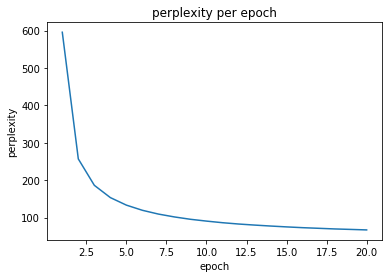

In [7]:
def plot_perp(pr_list):
## YOUR PLOTING CODE HERE
  import matplotlib.pyplot as plt
  x = np.array(range(1,len(pr_list)+1))
  plt.plot(x,pr_list)
  plt.title('perplexity per epoch')
  plt.xlabel('epoch')
  plt.ylabel('perplexity')
  plt.show()
  return
## END YOUR PLOTTING COD
plot_perp(pr_list)